# 1. import modules

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import linalg
%matplotlib inline
import mdtraj as md
import nglview as nv
import dmaps
import math
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from numpy import matlib as mb
import os
import pickle
import time

# 2. load trajectories

In [61]:
traj = md.load('trj_whole.xtc', top='traj_pbc.gro')[:5000]

# 3. calculate gyrate radius

In [62]:
def principal_ax(traj):
    traj.center_coordinates()
    X = np.array([X.T.dot(X)/X.shape[0] for X in traj.xyz])
    evecs = np.linalg.eigvalsh(X)[:,::-1]
    return np.sqrt(evecs)*10

In [63]:
gt = principal_ax(traj)

In [64]:
gt.shape

(5000, 3)

In [65]:
gt1 = gt[:,0]
gt2 = gt[:,1]
gt3 = gt[:,2]

# 4. calculate h2t distance

In [66]:
h2tdist = md.compute_distances(traj[:],[[0,23]])
length = len(h2tdist)

In [67]:
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'25'}

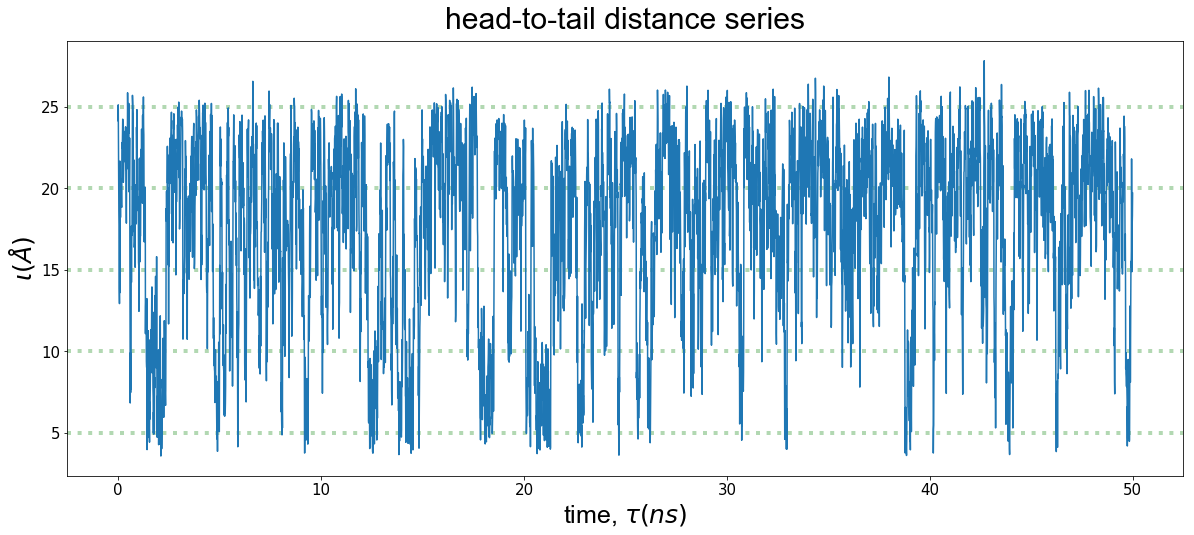

<Figure size 432x288 with 0 Axes>

In [68]:
fig, ax = plt.subplots(figsize = (20,8))
x = np.array(range(traj.xyz.shape[0]))
ax.plot(x/100, h2tdist*10)
ax.set_xlabel(r"time, $\tau (ns)$", **axis_font)
ax.set_ylabel(r"$\iota  (\AA)$" ,**axis_font) 
ax.grid(axis="y", color="green", alpha=.3, linewidth=4, linestyle=":")
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.draw()
plt.title("head-to-tail distance series", **title_font)
plt.show()
plt.savefig('h2tdistance.png')

In [69]:
print('the head-to-tail distance is in the range [%2.4f,%2.4f]'%(min(h2tdist),max(h2tdist)))

the head-to-tail distance is in the range [0.3585,2.7826]


In [70]:
np.savetxt('h2t series nystrom',h2tdist)

# 5. takens' delay embedding

In [71]:
# This code conduct delay embedding, given a time series O, delay time tau and
# delay dimension D, it create a D dimensional vectors EBD, and a pairwise
# distance matrix of the delayed points.

def delayembedding(dist,gt):

    d = int(input('Enter the dimension of embeding space:')) # determin dimension of embeding space
    tao = int(input('Enter the delay time T:')) # input delay time
    
    N = len(traj)
    L = N - d*tao
    M = np.zeros((L,d+1))
    
    gt1M = np.zeros((L,d+1)) 
    gt2M = np.zeros((L,d+1)) 
    gt3M = np.zeros((L,d+1)) 
    
    print('The original number of snapshots is %d, the nunmber of reconstructed points is %d\n'%(length, L)) #show change of # of data points
    
    M[:,0]= np.transpose(dist[0:L])
    for i in range(L):
        for j in range(1,d+1,1):
            M[i,j] = dist[i+j*tao]
            gt1M[i,j] = gt1[i+j*tao]
            gt2M[i,j] = gt2[i+j*tao]
            gt3M[i,j] = gt3[i+j*tao]
    
    return M,gt1M,gt2M,gt3M

In [72]:
M, gt1M, gt2M, gt3M = delayembedding(h2tdist,gt)

Enter the dimension of embeding space:19
Enter the delay time T:2
The original number of snapshots is 5000, the nunmber of reconstructed points is 4962



In [73]:
print(gt1M.shape,gt2M.shape,gt3M.shape,M.shape)

(4962, 20) (4962, 20) (4962, 20) (4962, 20)


In [74]:
np.savetxt('EBD-5000.txt', M)

In [75]:
np.savetxt('gt1M-5000.txt', gt1M)
np.savetxt('gt2M-5000.txt', gt2M)
np.savetxt('gt3M-5000.txt', gt3M)

# 6. average the gyration tensors

In [76]:
gt1 = np.zeros(gt1M.shape[0])
gt2 = np.zeros(gt2M.shape[0])
gt3 = np.zeros(gt3M.shape[0])

In [77]:
for i in range(gt1M.shape[0]):
    gt1[i] = np.mean(gt1M[i,:])
    gt2[i] = np.mean(gt2M[i,:])
    gt3[i] = np.mean(gt3M[i,:])

# 7. select points as base for diffusion map

In [93]:
EBDdata = M

In [94]:
EBDdata.shape

(4962, 20)

In [95]:
distEBDdata = dmaps.DistanceMatrix(EBDdata.reshape(-1,20))


In [96]:
print("Starting pivot...")
#f = open('pivot_matrix.npy', 'wb')
r_cut =0.95

N = EBDdata.shape[0]
print(f"Finding the pivot for {N} data points")
P = np.zeros(N)
n=-1
start = time.time()
for i in range(N):
    if P[i]==0:
        P[i]=1
        n+=1
        temp = distEBDdata.compute_single(EBDdata[n],metric=dmaps.metrics.euclidean)
        P = np.where(np.logical_and(temp <= r_cut,P==0),2,P)
        #np.save(f,temp)
    if (i%100==0):
        print(100*i/N," % Done")
print("Pivot finished in {} seconds".format(time.time()-start))
#f.close()
print("Pivot Done!")
f = open('pivot_P_every20.npy', 'wb')
np.save(f,P)
f.close()


Starting pivot...
Finding the pivot for 4962 data points
0.0  % Done
2.015316404675534  % Done
4.030632809351068  % Done
6.045949214026602  % Done
8.061265618702135  % Done
10.07658202337767  % Done
12.091898428053204  % Done
14.107214832728738  % Done
16.12253123740427  % Done
18.137847642079805  % Done
20.15316404675534  % Done
22.168480451430874  % Done
24.183796856106408  % Done
26.199113260781942  % Done
28.214429665457477  % Done
30.22974607013301  % Done
32.24506247480854  % Done
34.26037887948408  % Done
36.27569528415961  % Done
38.29101168883515  % Done
40.30632809351068  % Done
42.32164449818622  % Done
44.33696090286175  % Done
46.352277307537285  % Done
48.367593712212816  % Done
50.382910116888354  % Done
52.398226521563885  % Done
54.41354292623942  % Done
56.42885933091495  % Done
58.44417573559049  % Done
60.45949214026602  % Done
62.47480854494155  % Done
64.49012494961708  % Done
66.50544135429263  % Done
68.52075775896816  % Done
70.53607416364369  % Done
72.5513905

In [97]:
n

4267

In [98]:
traj_n = np.zeros((N,20))
traj_N_n = np.zeros((N,20))
gt1final_n = np.zeros(N)
gt2final_n = np.zeros(N)
gt3final_n = np.zeros(N)
gt1final_N_n = np.zeros(N)
gt2final_N_n = np.zeros(N)
gt3final_N_n = np.zeros(N)

In [99]:
for i in range(P.shape[0]):
    if P[i] == 1:        
        traj_n[i,:] = M[i,:]
        gt1final_n[i] = gt1[i]
        gt2final_n[i] = gt2[i]
        gt3final_n[i] = gt3[i]
        
    elif P[i] == 2:
        traj_N_n[i,:] = M[i,:]
        gt1final_N_n[i] = gt1[i]
        gt2final_N_n[i] = gt2[i]
        gt3final_N_n[i] = gt3[i]

In [100]:
traj_n = traj_n[np.nonzero(gt1final_n),:]

In [101]:
gt1final_n = gt1final_n[np.nonzero(gt1final_n)]
gt2final_n = gt2final_n[np.nonzero(gt2final_n)]
gt3final_n = gt3final_n[np.nonzero(gt3final_n)]

In [102]:
traj_N_n = traj_N_n[np.nonzero(gt1final_N_n),:]

In [103]:
gt1final_N_n = gt1final_N_n[np.nonzero(gt1final_N_n)]
gt2final_N_n = gt2final_N_n[np.nonzero(gt2final_N_n)]
gt3final_N_n = gt3final_N_n[np.nonzero(gt3final_N_n)]

# 8. symmetry elimination

In [104]:
EBDdata = traj_n

In [105]:
EBDdata = EBDdata.reshape(n+1,20)

In [106]:
EBDdata.shape

(4268, 20)

In [107]:
fliplrEBD = np.zeros(EBDdata.shape)
fliplrEBD = np.fliplr(EBDdata)

In [108]:
distEBDdata = dmaps.DistanceMatrix(EBDdata.reshape(-1,20*1))
distEBDdata.compute(metric=dmaps.metrics.euclidean)

In [109]:
distfliplrEBD = dmaps.DistanceMatrix(fliplrEBD.reshape(-1,20*1))
distfliplrEBD.compute(metric=dmaps.metrics.euclidean)

In [110]:
dist_EBDdata = distEBDdata.get_distances()

In [111]:
dist_flpiEBD = distfliplrEBD.get_distances()

In [112]:
optimizeddata = np.zeros((n+1,n+1))

In [113]:
for i in range(optimizeddata.shape[0]):  
    for j in range(optimizeddata.shape[0]):
        
        optimizeddata[i,j] = min(dist_flpiEBD[i,j],dist_EBDdata[i,j])        

In [114]:
np.savetxt('ebd_optimized_pivot.txt',optimizeddata)

In [115]:
dmap = dmaps.DiffusionMap(optimizeddata)

In [116]:
epss = 2.**np.arange(-4, 4, 1)


In [117]:
aij = [dmap.sum_similarity_matrix(eps) for eps in epss]


(0, 8)

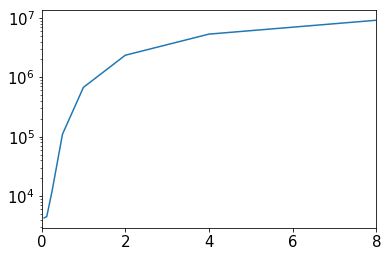

In [118]:
plt.semilogy(epss, aij)
plt.xlim([0, 8])


In [119]:
dmap.set_kernel_bandwidth(4)
dmap.compute(20)


In [120]:
vEBDdata = dmap.get_eigenvectors()
wEBDdata = dmap.get_eigenvalues()


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


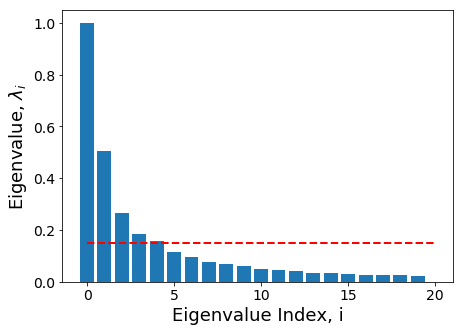

In [121]:
plt.figure(figsize=(7,5))
plt.bar(np.array(range(20)), wEBDdata)
ax = plt.subplot(1,1,1)
ax.set_xlabel('Eigenvalue Index, i',fontsize = 18)
ax.set_ylabel('Eigenvalue, $\lambda_i$',fontsize = 18)
ax.tick_params(labelsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.plot([-0,20], [0.15, 0.15], '--', lw=2,color = 'r')

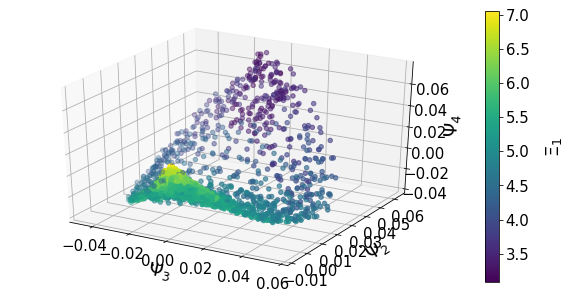

In [122]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(-vEBDdata[:,2], -vEBDdata[:,1], vEBDdata[:,3], c=gt1final_n[:n+1], marker='o')
ax.set_xlabel(r'$\Psi_3$',fontsize=18)
ax.set_ylabel(r'$\Psi_2$',fontsize=18)
ax.set_zlabel(r'$\Psi_4$',fontsize=18)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\Xi_1$', rotation=90,fontsize=18)
plt.draw()
plt.show()

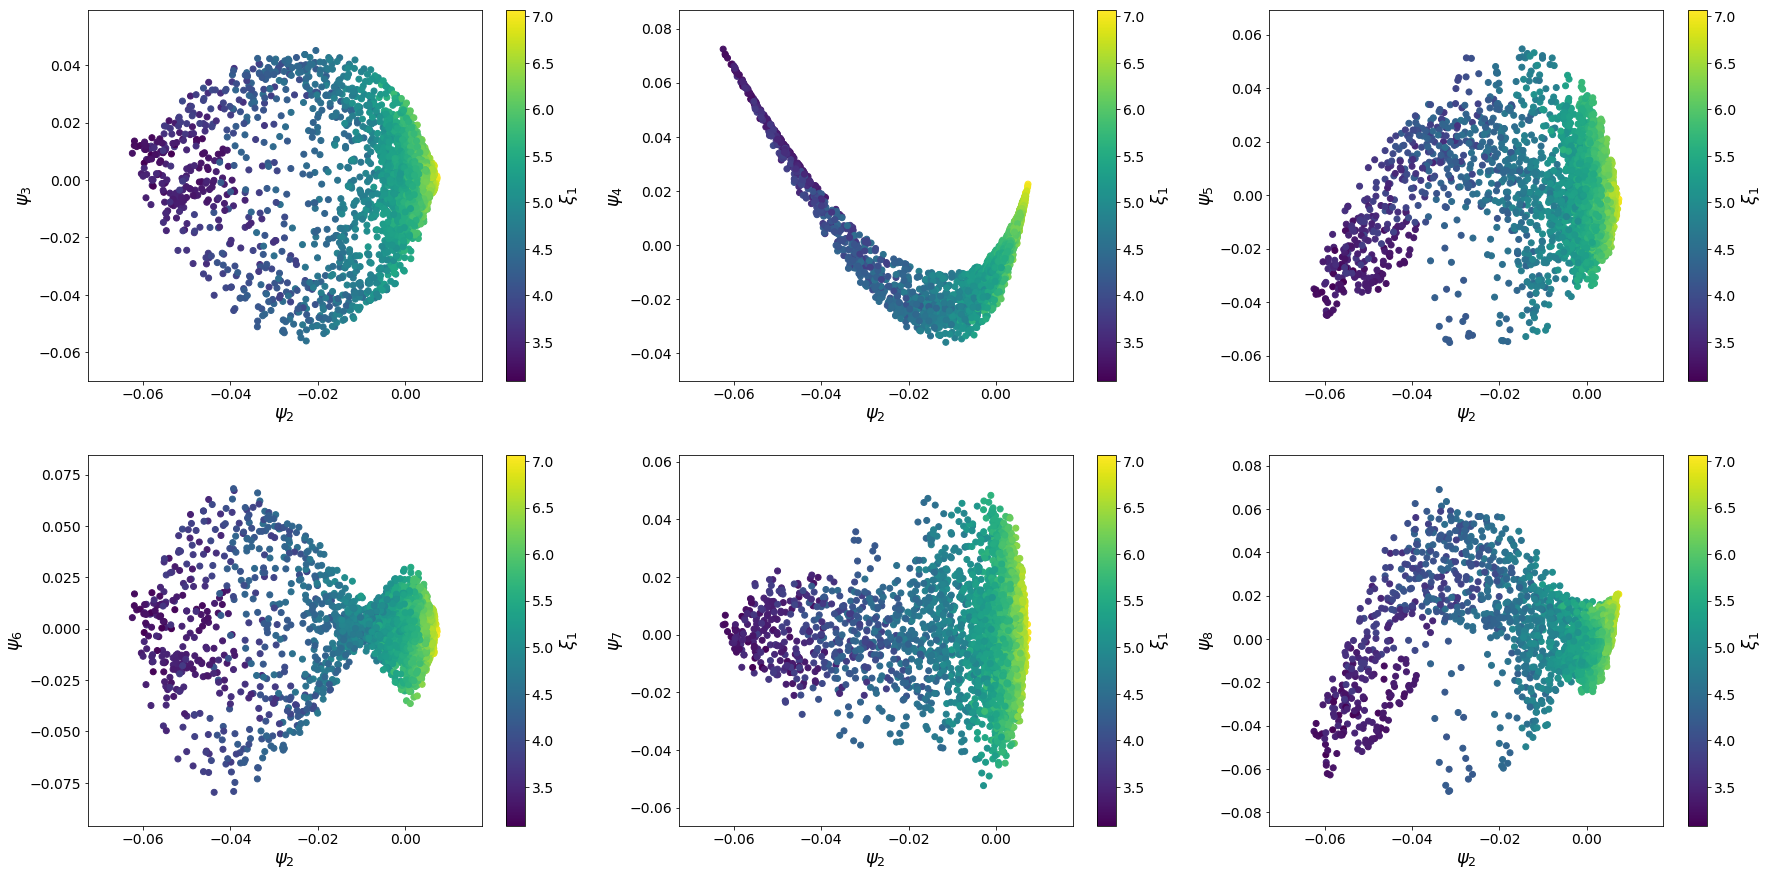

In [123]:
plt.figure(figsize=(30,15))
    # plotting trajectories 

ax1 = plt.subplot(2,3,1)
plt.scatter(vEBDdata[:,1], vEBDdata[:,2], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_3$',fontsize=18)
ax1.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax2 = plt.subplot(2,3,2)
plt.scatter(vEBDdata[:,1], vEBDdata[:,3], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_4$',fontsize=18)
ax2.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax3 = plt.subplot(2,3,3)
plt.scatter(vEBDdata[:,1], vEBDdata[:,4], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_5$',fontsize=18)
ax3.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)  

ax4 = plt.subplot(2,3,4)
plt.scatter(vEBDdata[:,1], vEBDdata[:,5], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_6$',fontsize=18)
ax4.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax5 = plt.subplot(2,3,5)
plt.scatter(vEBDdata[:,1], vEBDdata[:,6], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_7$',fontsize=18)
ax5.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax6 = plt.subplot(2,3,6)
plt.scatter(vEBDdata[:,1], vEBDdata[:,7], c=gt1final_n)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_8$',fontsize=18)
ax6.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

# 9. Nystrom Extension

In [124]:
nystrom_ebd = np.zeros((4962,20))


In [125]:
nystrom_ebd[:n+1] = vEBDdata


In [126]:
for i in range(N-n-1):
    nystrom_ebd[n+i+1] = dmap.nystrom(distEBDdata.compute_single(traj_N_n.reshape(N-n-1,20)[i].reshape(-1),metric=dmaps.metrics.euclidean))
    

In [127]:
gt1final_n.shape


(4268,)

In [128]:
gt1final_N_n.shape


(694,)

In [129]:
gt11 = np.zeros(N)


In [130]:
gt11[:n+1] = gt1final_n


In [131]:
gt11[n+1:] = gt1final_N_n


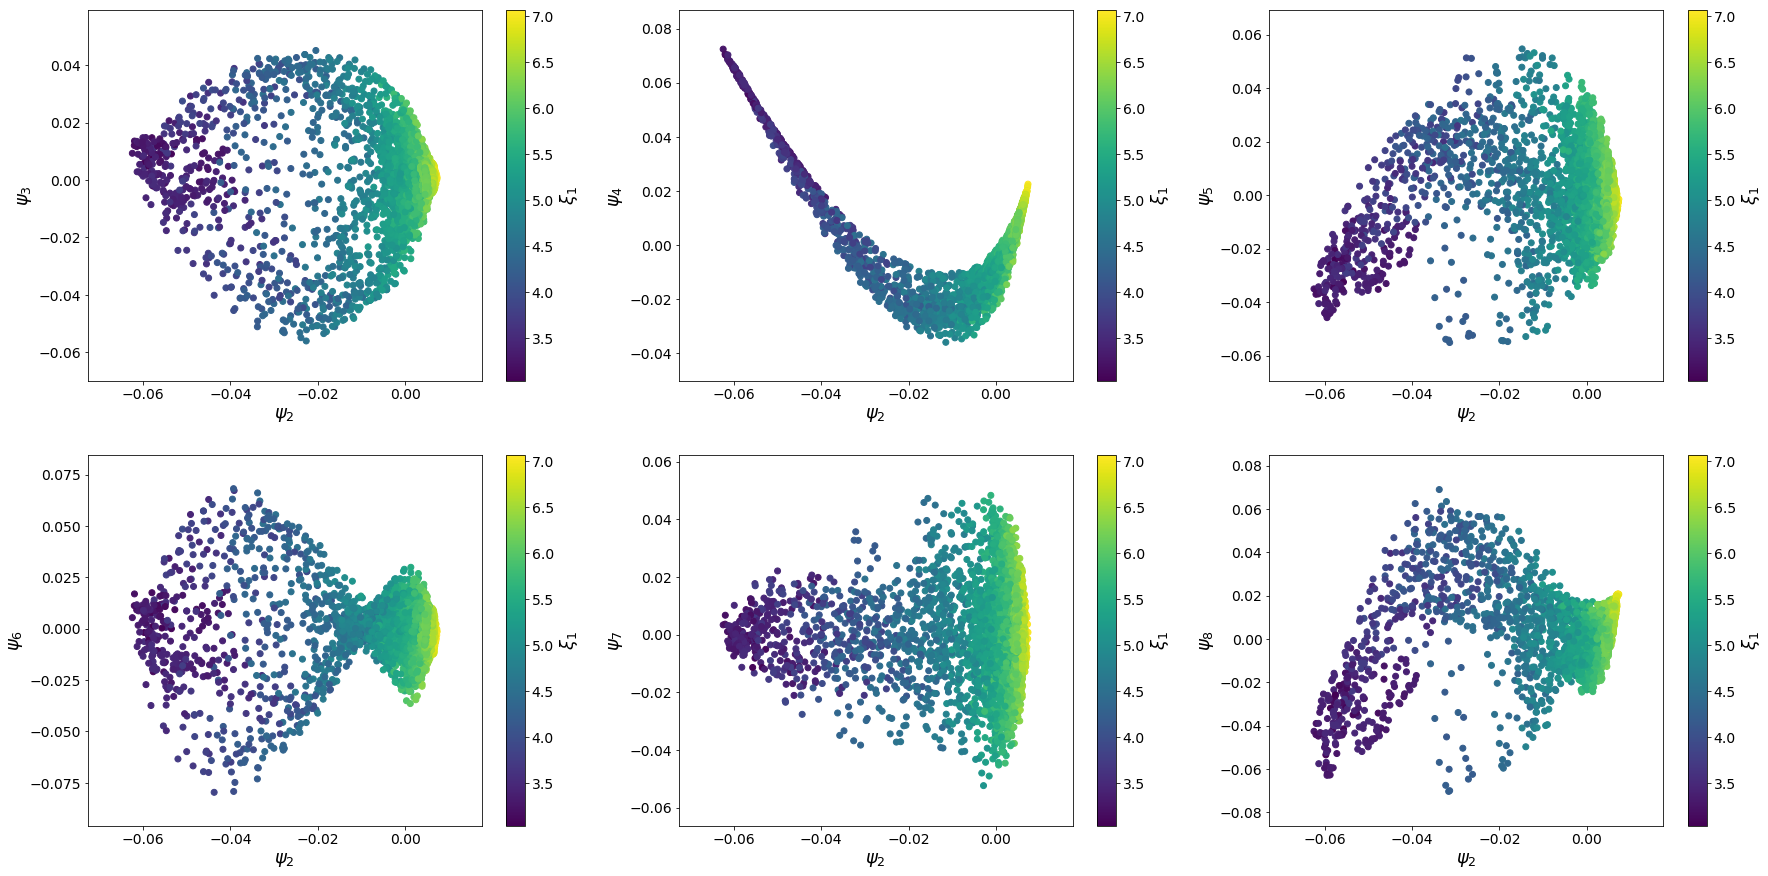

In [132]:
plt.figure(figsize=(30,15))
    # plotting trajectories 

ax1 = plt.subplot(2,3,1)
plt.scatter(nystrom_ebd[:,1], nystrom_ebd[:,2], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_3$',fontsize=18)
ax1.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax2 = plt.subplot(2,3,2)
plt.scatter(nystrom_ebd[:,1], nystrom_ebd[:,3], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_4$',fontsize=18)
ax2.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax3 = plt.subplot(2,3,3)
plt.scatter(nystrom_ebd[:,1], nystrom_ebd[:,4], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_5$',fontsize=18)
ax3.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)  

ax4 = plt.subplot(2,3,4)
plt.scatter(nystrom_ebd[:,1], nystrom_ebd[:,5], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_6$',fontsize=18)
ax4.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax5 = plt.subplot(2,3,5)
plt.scatter(nystrom_ebd[:,1], nystrom_ebd[:,6], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_7$',fontsize=18)
ax5.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

ax6 = plt.subplot(2,3,6)
plt.scatter(nystrom_ebd[:,1], nystrom_ebd[:,7], c=gt11)
cbar = plt.colorbar()
plt.xlabel(r'$\psi_2$',fontsize=18)
plt.ylabel(r'$\psi_8$',fontsize=18)
ax6.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'$\xi_1$',fontsize=18)

In [133]:
np.savetxt('pivot_nystrom_ebd.txt',nystrom_ebd[:,1:])
